In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

In [6]:
class Pan_Tompkins:
    def __init__(self, ecg_data, fs=250):
        self.ecg = ecg_data
        self.fs = fs
        self.filtered = None
        self.threshold = None
        self.deriv = None
        self.squared = None
        self.integrated = None

    def bp_filter(self, low, high, order=2):
        # 평균 0 (drift 제거)도 함께 수행 권장
        ecg_zero_mean = self.ecg - np.mean(self.ecg)
        from scipy.signal import butter, filtfilt
        nyq = 0.5 * self.fs
        low_n = low / nyq
        high_n = high / nyq
        b, a = butter(order, [low_n, high_n], btype='band')
        self.filtered = filtfilt(b, a, ecg_zero_mean)
        return self.filtered

    def derivative(self):
        kernel = np.array([1,2,0,-2,-1]) / 8
        self.deriv = np.convolve(self.filtered, kernel, mode='same')
        return self.deriv

    def square(self):
        self.squared = self.deriv ** 2
        return self.squared

    def mwi(self, window_size_ms=150):
        window = int(self.fs * window_size_ms / 1000)
        if window < 1:
            window = 1    
        kernel = np.ones(window) / window
        self.integrated = np.convolve(self.squared, kernel, mode='same')
        return self.integrated

In [7]:
def detect_peaks(integrated, fs=250, refractory_ms=200):
    rpeaks = []
    SPKI = np.max(integrated[:fs]) 
    NPKI = np.mean(integrated[:fs]) 
    threshold_i = NPKI + 0.25 * (SPKI - NPKI)
    refractory_period = int(fs * refractory_ms / 1000)
    last_qrs = -refractory_period

    for i in range(1, len(integrated)-1):
        if integrated[i] > integrated[i-1] and integrated[i] > integrated[i+1]:
            peak_amp = integrated[i]
            if(len(rpeaks) > 0) and ((i - rpeaks[-1]) < refractory_period):
                continue
            if peak_amp > threshold_i:
                rpeaks.append(i)
                SPKI = 0.125 * peak_amp + 0.875 * SPKI
            else:
                NPKI = 0.125 * peak_amp + 0.875 * NPKI
            threshold_i = NPKI + 0.25 * (SPKI - NPKI)
    rpeaks = np.array(rpeaks)

    rr_intervals = np.diff(rpeaks)
    mean_rr = np.mean(rr_intervals) if len(rr_intervals) > 0 else refractory_period

    missed_peaks = []
    for idx in range(1, len(rpeaks)):
        if rr_intervals[idx-1] > 1.66 * mean_rr:
            start = rpeaks[idx-1] + refractory_period
            end = rpeaks[idx] - refractory_period
            for i in range(start, end):
                if (integrated[i] > 0.5 * threshold_i and
                    integrated[i] > integrated[i-1] and
                    integrated[i] > integrated[i+1]):
                    if np.all(np.abs(rpeaks - i) > refractory_period):
                        missed_peaks.append(i)
    all_peaks = np.sort(np.concatenate([rpeaks, missed_peaks]).astype(int))
    return np.array(all_peaks, dtype=int)


def refine_peaks(raw_ecg, rpeak_indices, search_radius=20):
    refined = []
    for idx in rpeak_indices:
        start = max(0, idx - search_radius)
        end = min(len(raw_ecg), idx + search_radius + 1)
        win = raw_ecg[start:end]
        if len(win) == 0:
            continue
        local_peak = np.argmax(win)
        refined.append(start + local_peak)
    return np.array(refined)

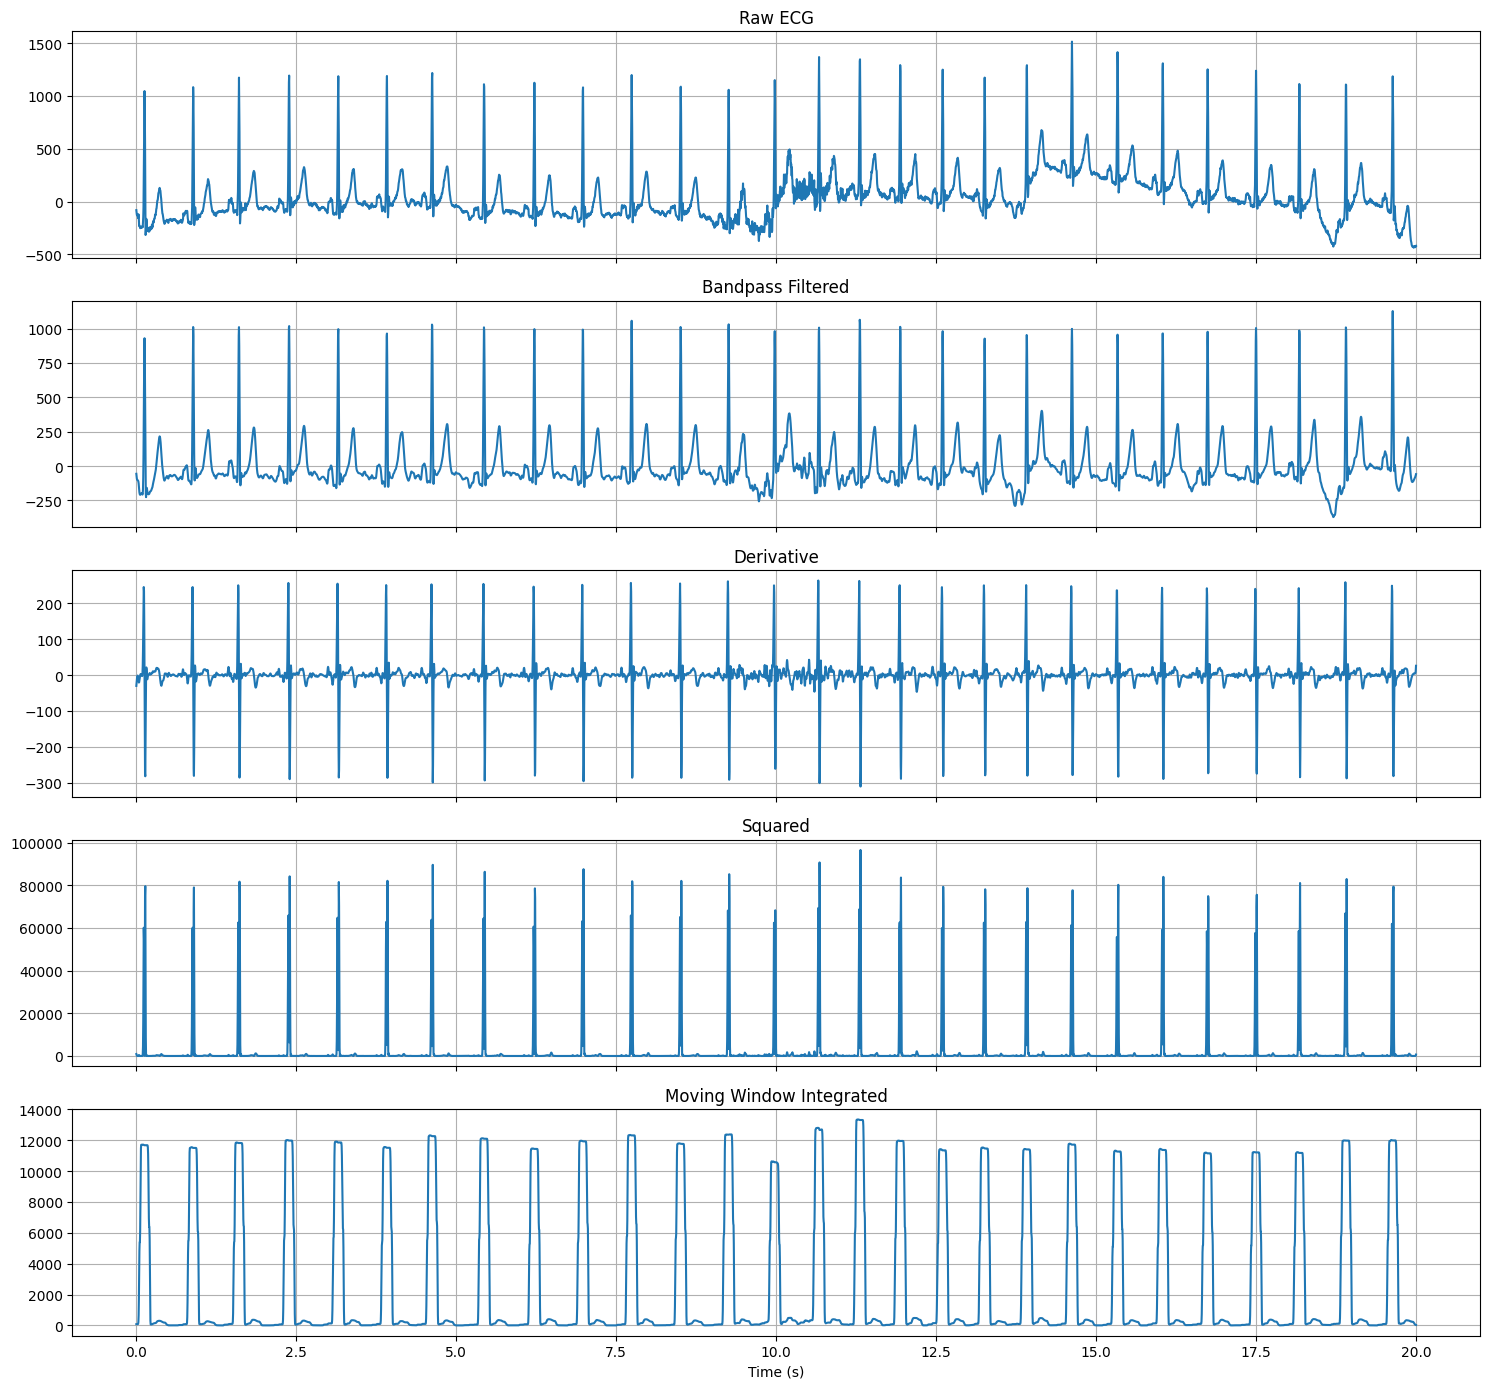

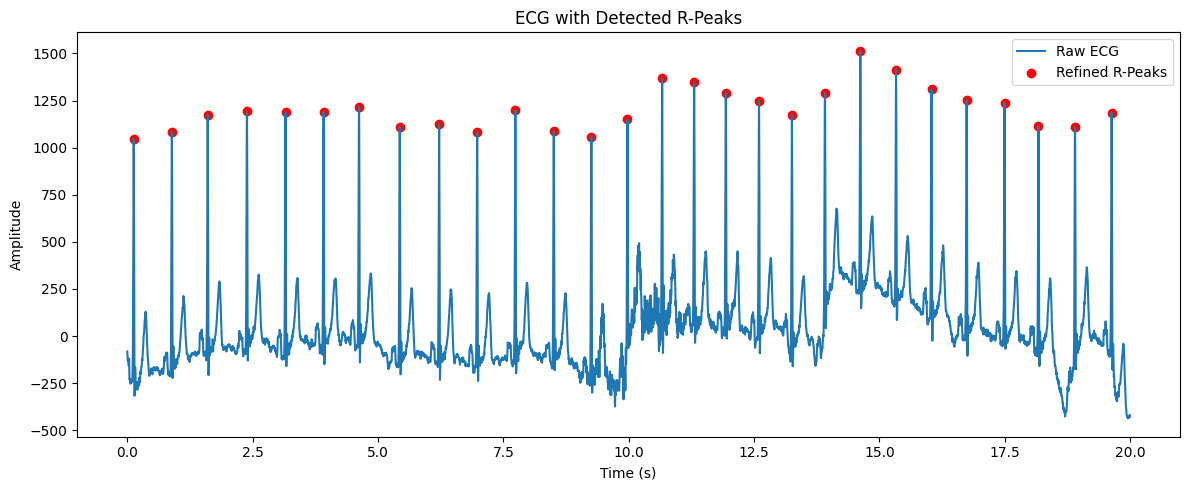

In [8]:
ecg = np.loadtxt('data_sample/PSG_ECG_220317_211.txt')
fs = 250

duration_sec = 20
num_samples = duration_sec * fs
ecg_cut = ecg[:num_samples]

pt = Pan_Tompkins(ecg_cut, fs)
pt.bp_filter(0.5, 35)
pt.derivative()
pt.square()
pt.mwi(window_size_ms=150)

detected_rpeaks = detect_peaks(pt.integrated, fs=fs, refractory_ms=200)
refined_rpeaks = refine_peaks(pt.ecg, detected_rpeaks, search_radius=20)

fig, axes = plt.subplots(5, 1, figsize=(15, 14), sharex=True)

t = np.arange(len(pt.ecg)) / fs
axes[0].plot(t, pt.ecg)
axes[0].set_title('Raw ECG')
axes[1].plot(t, pt.filtered)
axes[1].set_title('Bandpass Filtered')
axes[2].plot(t, pt.deriv)
axes[2].set_title('Derivative')
axes[3].plot(t, pt.squared)
axes[3].set_title('Squared')
axes[4].plot(t, pt.integrated)
axes[4].set_title('Moving Window Integrated')

for ax in axes:
    ax.grid(True)
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(t, pt.ecg, label='Raw ECG')
plt.scatter(refined_rpeaks / fs, pt.ecg[refined_rpeaks], color='red', label='Refined R-Peaks')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('ECG with Detected R-Peaks')
plt.legend()
plt.tight_layout()
plt.show()